# <font style="color:rgb(50,120,229)"> EE5/7382 – Fundamentals of Computer Vision - Homework 4
</font>

##### **<font color="red">Detecting circles of known radius using Hough Transform  (45 points)</font>**
As part of this assignment you will be implementing an algorithm to detect circles of known radius, in an image, using the Hough Transform discussed in the lecture. Your task is to identify circles in the images `FaceCloseUp.jpg` and `PokerChips.png`, included with the assignment.
<br>
Please read the instructions supplied with the homework for guidance on implementing the Hough Transform and deliverables.  

##### <font color="yellow">Preamble</font>

In [37]:
# Preamble
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np

#### <font color="yellow">Implementation of `houghTransform_for_Circle(bwEdgeMap, radius)` goes here</font><br><font color="red">(20 points)</font>
The function accepts an edge map `bwEdgeMap` and `radius` of the circle to detect in the image. 
The function should output the following
* Hough accumulator matrix `mtxA`
* Hough parameter space `(a,b)` associated with the (col,row) indices of candidate circle centers

<font color="cyan"><b>Implementation Hints</b></font>
<br>
To identify the (row,col) indices of non-zero pixels in the edge map `bwEdgeMap` use the numPy function `nonzero()`
Lookup https://numpy.org/doc/stable/reference/generated/numpy.nonzero.html for additional help.

In [38]:
def houghTransform_for_Circles(bwEdgeMap, radius):
    [nR,nC] = bwEdgeMap.shape

    # The Hough Accumulator array for circles is parametrized by two
    # quantities: the center of each circle
    # The candidate centers could be anywhere in the image
    # Thus, the houghSpace must have size nR x nC
    [yE,xE] = np.nonzero(bwEdgeMap)    # https://numpy.org/doc/stable/reference/generated/numpy.nonzero.html 
    nE = xE.shape[0]

    # Define Hough Parameter Space
    a = np.arange(0,nC,1)       # 0 <= a < nC
    b = np.arange(0,nR,1)       # 0 <= b < nR

    # Angle parameter used to define points on circle
    theta = np.arange(0,360,1)    # 0 <= theta < 360

    # Initialize storage for accumulator array
    #   -as many rows as number of rows in image
    #   -as many columns as number of cols in image
    mtxA = np.zeros([nR,nC])

    # iterate over all edge points
    for n in np.arange(nE):    
    # iterate over all points that make up circle with known radius 
      # Points on circumference of circle with center <<(xE,yE)>> and radius <<radius>>
      xC = xE[n] + radius * np.cos(theta*np.pi/180)
      yC = yE[n] - radius * np.sin(theta*np.pi/180)
      #
      # Lookup nearest points (a_star,b_star) on pixel grid
      a_star = np.maximum(np.minimum(np.round(xC),nC-1),0)
      a_star = a_star.astype(np.int32)
      b_star = np.maximum(np.minimum(np.round(yC),nR-1),0)
      b_star = b_star.astype(np.uint32)  
      #
      # lind = np.ravel_multi_index( (bstar,astar), (nR,nC) )
      # print(mtxA[lind[np.arange(3)]])
      for ell in np.arange(a_star.shape[0]):
        mtxA[b_star[ell],a_star[ell]] += 1
          
    # Clean-up
    # The boundary of the Hough space contains strong and spurious peaks
    # Null them out to avoid confusion
    mtxA[0,:] = 0
    mtxA[-1,:] = 0
    mtxA[:,0] = 0
    mtxA[:,-1] = 0
  
    return mtxA, a, b


#### <font color="yellow">Implementation of `NMS_HTCircles_Accumulator(mtxA, numCircle)` goes here</font><br><font color="red">(20 points)</font>
The function accepts the following input arguments
  * Hough Accumulator matrix `mtxA`. Each entry of this matrix represents the number of votes cast for a candidate circle center.
  * Size of Neighborhood `szNbrHood` over which to attempt Non-Maximum suppression  
  * A threshold `NMS_thresh` for discarding spurious local maxima with few votes
  * The number of circles(peaks) to detect `numCircles` in Hough Space 
  
The function should output the (Col,Row) coordinates `(xC,yC)` of candidate circle centers

<font color="cyan"><b>Implementation Hints</b></font>
* Non Maximum Suppression (NMS)
  * Use OpenCV function `dilate` to implement statistical order filtering over neighborhood.<br>
    See https://docs.opencv.org/3.4/db/df6/tutorial_erosion_dilatation.html for more details.
    <font color="red">Why is this is a computationally efficient alternative to computing the maximum over a neighborhood? </font> 
  * The neighborhood is defined in <font color="cyan">Line-6</font>, and referred to as the <b>Structuring Element</b>
  * Store the result of `dilate` in numpy array `LCLMX_mtxA`: local maximum representation of `mtxA`
  * Find entries in `mtxA` which simultaneously satisfy `mtxA >= LCLMX_mtxA` and `mtxA >= NMS_THRESH`
    * `mtxA >= LCLMX_mtxA` discards values which responds to local maxima
    * `mtxA >= NMS_THRESH` discards local maxima in `mtxA` with few votes (spurious responses)
    * Store result of this operation in logical array `mask`
* Assemble result of NMS in matrix `NMS_mtxA` (<font color="cyan">Lines 17,18</font>)
* Sort entries of `NMS_mtxA[mask]` in descending order
  * Find top `numCircles` entries and their corresponding position in the array `NMS_mtxA`.
    <br> 
    The following numPy functions may be of help: `argsort`,`flip`,`unravel_index`
  * The (column,row) values of the top `numCircles` entries in `NMS_mtxA` correspond to the center of the circles with desired radius  
    * Store column & row values in arrays `xC` and `yC` respectively (<font color="cyan">Line 25</font>)

In [39]:
def NMS_HTCircles_Accumulator(mtxA, szNbrHood, NMS_THRESH, numCircles):
    # Replace each pixel with maximum over neighborhood of size = circle diameter                                  
    #   https://docs.opencv.org/3.4/db/df6/tutorial_erosion_dilatation.html
    strElm = cv.getStructuringElement(cv.MORPH_RECT,[szNbrHood,szNbrHood])
    LCLMX_mtxA = cv.dilate(mtxA,strElm)

    ####################################################################################
    # Find pixels for which mtxA >= LCLMX_mtxA and mtxA >= NMS_THRESH
    #   mtxA >= LCLMX_mtxA          check if vote is a local maximum
    #   mtxA >= NMS_THRESH          check if vote exceeds threshold (discard weak votes)
    ####################################################################################
    mask = (mtxA >= LCLMX_mtxA) & (mtxA >= NMS_THRESH)

    # Store result of NMS 
    NMS_mtxA = np.zeros(mtxA.shape) 
    NMS_mtxA[mask] = mtxA[mask]

    ##################################################
    # Sort the entries of NMS_mtxA in descending order 
    ##################################################
    # https://numpy.org/doc/stable/reference/generated/numpy.argsort.html
    # https://numpy.org/doc/stable/reference/generated/numpy.unravel_index.html
    # argsort() identifies the indices into sorts in ascending order, 
    # flip() reverses the order 
    [yC,xC] = np.unravel_index(np.flip(np.argsort(NMS_mtxA,axis=None)),NMS_mtxA.shape)

    # Retain only the top numCircles entries
    xC = xC[0:numCircles]
    yC = yC[0:numCircles]

    return xC, yC

#### <font color="yellow">Step1-: Read the images using `imread()`</font>

In [40]:
fileName = ('FaceCloseUp.jpg','PokerChips.png')
imgNum = 1  # default is FaceCloseUp.jpg
dirPath = '.\\Data_HoughTransform\\'

# Read in Grayscale mode
imRGB = cv.imread( dirPath + fileName[imgNum] )
im = cv.imread( dirPath + fileName[imgNum] , cv.IMREAD_GRAYSCALE )

#### <font color="yellow">Step-2: Canny Edge Detection using `canny()`</font>

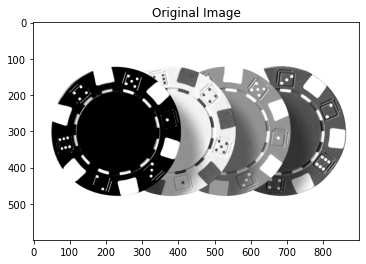

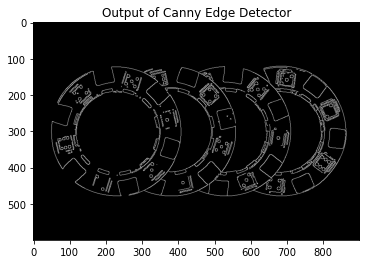

In [41]:
im_binary = cv.Canny(im,100,200)

# Display Original Image
plt.figure()
plt.imshow(im,cmap = 'gray')
plt.title('Original Image'), # plt.grid() 
plt.show()

# Display Edge Map
plt.figure()
plt.imshow(im_binary,cmap = 'gray')
plt.title('Output of Canny Edge Detector'), # plt.grid()
plt.show()

#### <font color="yellow">Step-3: Call `houghTransform_for_Circle()`</font>

In [42]:
# Hough Transform Parameters
if fileName[imgNum] == 'FaceCloseUp.jpg':
    radius = 36         # radius of circle we wish to find
    numCircles = 2      # number of Hough peaks to report
elif fileName[imgNum] == 'PokerChips.png':
    radius = 175         # radius of circle we wish to find
    numCircles = 4      # number of Hough peaks to report
else:
    print('Unknown Image')
     
# Call houghTransform_for_Circles() 
[mtxA,a,b] = houghTransform_for_Circles(im_binary, radius)

# # Display the Hough Accumulator Map
# plt.figure()
# plt.imshow(mtxA,cmap='gray')
# plt.xticks(a[::50],fontsize=8)
# plt.yticks(b[::50],fontsize=8)
# plt.colorbar(location='right',shrink=0.5)
# str = 'Hough Accumulator Map for circles of radius {0}'.format(radius)
# plt.title(str)

#### <font color="yellow">Step-4: Non-maximum Suppression of Hough Accumulator Map</font>
<font color="cyan"><b>Implementation Hints</b></font>
* Try setting `szNbrHood` to the radius of the circles you wish to detect
* Try setting the threshold as a fraction of the peak value in `mtxA`
  * A small value for the threshold (`0.05*np.max(mtxA)`) might not eliminate spurious circle candidates
  * A large value of threshold (`0.85*np.max(mtxA)`) might eliminate actual circle candidates   

Text(0.5, 1.0, 'Hough Accumulator Map for circles of radius 175')

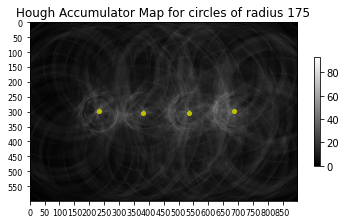

In [43]:
# Threshold for Non-Maximum Suppression
NMS_THRESH = 0.4*np.max(mtxA)

# Call houghTransform_for_Circles() 
[xC,yC] = NMS_HTCircles_Accumulator(mtxA,radius,NMS_THRESH,numCircles)

# Display the Hough Accumulator Map & overlay Hough maxima
plt.figure()
plt.imshow(mtxA,cmap='gray')
plt.plot( xC[0:numCircles],yC[0:numCircles], color='y', marker='o', markersize=4, linestyle='none' )
plt.xticks(a[::50],fontsize=8)
plt.yticks(b[::50],fontsize=8)
plt.colorbar(location='right',shrink=0.5)
str = 'Hough Accumulator Map for circles of radius {0}'.format(radius)
plt.title(str)

#### <font color="yellow">Step-5: Display the result</font>
* Display the original image (<font color="cyan">Line 2</font>)
  * OpenCV indexes images in BGR format, and not RGB
  * Convert from BRG indexing to RGB indexing before displaying using matplotlib's `imshow` (<font color="cyan">Line 2</font>)
* Create circle objects using the `Circle` method built-into matplotlib (<font color="cyan">Line 11</font>)
* Add each circle to list of patches (<font color="cyan">Line 12</font>) 
* Display the result (<font color="cyan">Line 11</font>)

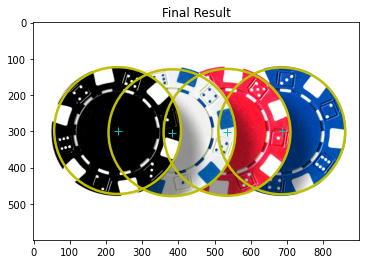

In [44]:
from matplotlib.patches import Circle

fig, ax = plt.subplots(1)
ax.imshow(cv.cvtColor(imRGB,cv.COLOR_BGR2RGB))
plt.title('Final Result')
#
# Look at the top <numCircles> entries in vals
for n in np.arange(numCircles):
    ax.plot( xC[n],yC[n], color='c', marker='+', markersize=8 )
    hnd = Circle([xC[n],yC[n]],radius,fill=False,color='y',linewidth=2.5)
    ax.add_patch(hnd)
#   
plt.show()


#### <font color="yellow">Step-6: Locate the red poker chip</font> (ECE7382 only)<br><font color="red">(10 points)</font>
Modify the code so that you only detect the red poker chip in the image `PokerChips.png`.

<font color="cyan"><b>Implementation Hints</b></font>
Check the mean RGB values in the circular patch (known radius) immediately surrounding each candidate circle center. The OpenCV function `circle()` may help in your attempts to mask out the Region-of-Interest surrounding each candidate center. 
Check out https://pyimagesearch.com/2021/01/19/image-masking-with-opencv/ for ideas.

Useful functions: `np.mean()`, `cv.circle()`, `np.bitwise_and()`

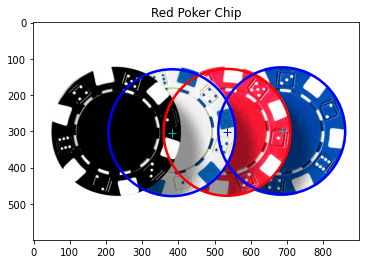

In [45]:
from matplotlib.patches import Circle

fig, ax = plt.subplots(1)
ax.imshow(cv.cvtColor(imRGB,cv.COLOR_BGR2RGB))
plt.title('Red Poker Chip')

if fileName[imgNum] == 'PokerChips.png':
    imB = imRGB[:,:,0].astype('double')     # Blue color plane of RGB image
    imG = imRGB[:,:,1].astype('double')     # Green color plane of RGB image
    imR = imRGB[:,:,2].astype('double')     # Red color plane of RGB image
    muROI_R = 0.0
    muROI_G = 0.0
    muROI_B = 0.0
    #
    for n in np.arange(numCircles):
        # mask image
        mask = np.zeros(imRGB.shape[:2], dtype='uint8')
        # https://www.geeksforgeeks.org/python-opencv-cv2-circle-method/
        # white filled circle
        cv.circle(mask, (xC[n],yC[n]), radius, 255, -1)

        # check mean value in all three color planes ignoring zeros
        muROI_R = np.mean(imR[mask > 0])
        muROI_G = np.mean(imG[mask > 0])
        muROI_B = np.mean(imB[mask > 0])

        # If mu_Red > mu_Green and mu_Red > mu_Blue, odd's are its a red poker chip
        if np.bitwise_and(muROI_R > muROI_G, muROI_R > muROI_B):
            ax.plot( xC[n],yC[n], color='b', marker='+', markersize=8 )
            hnd = Circle([xC[n],yC[n]],radius,fill=False,color='r',linewidth=2.5)
            ax.add_patch(hnd)
        
        if np.bitwise_and(muROI_B > muROI_G, muROI_B > muROI_R):
            ax.plot( xC[n],yC[n], color='c', marker='+', markersize=8 )
            hnd = Circle([xC[n],yC[n]],radius,fill=False,color='b',linewidth=2.5)
            ax.add_patch(hnd)
#   
plt.show()        